<a href="https://colab.research.google.com/github/ankithakumari/SupervisedML/blob/master/XGBoost_FeatureImportance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn import model_selection, linear_model, metrics, discriminant_analysis
from sklearn.ensemble import RandomForestClassifier
import xgboost



In [188]:
from google.colab import files
uploaded = files.upload()


In [0]:
credit_data = pd.read_csv('German_Final.csv')
y = credit_data['ClassificationStatus']

In [0]:
for item in y:
  if item == 0:
    item = 1
  else:
    item = 0

In [0]:
def reset_data():
    # train test split 70:30 using stratify
    X_train, X_test, y_train, y_test = model_selection.train_test_split(credit_data.loc[:, credit_data.columns != 'ClassificationStatus'], y, test_size=0.30, stratify=y)
    # Use one-hot encoding for categorical variables 
    cat_preds = [column for column in X_train.columns if len(credit_data[column].unique()) <= 10]
    continuous_preds = [column for column in X_train.columns if len(credit_data[column].unique()) > 10]
    continuous_preds.append('DurationInCurrentResidence')
    continuous_preds.append('InstallmentRate')
    cat_preds.remove('DurationInCurrentResidence')
    cat_preds.remove('InstallmentRate')
    X_train = pd.get_dummies(X_train, columns=cat_preds, drop_first= True)
    X_test = pd.get_dummies(X_test, columns=cat_preds, drop_first=True)
    return (X_train, X_test, y_train, y_test)



In [0]:

X_train, X_test, y_train, y_test = reset_data()

In [0]:
X_train1 = X_train.rename(columns={'SavingsAccount_[100, 500) DM': 'SavingsAccount_(100, 500) DM', 'SavingsAccount_[500, 1000) DM': 'SavingsAccount_(500, 1000) DM', 'CurrentEmplymentStatus_[1, 4) Years' : 'CurrentEmplymentStatus_(1, 4) Years', "CurrentEmplymentStatus_[4, 7) Years": "CurrentEmplymentStatus_(4, 7) Years"})
X_test1 = X_test.rename(columns={'SavingsAccount_[100, 500) DM': 'SavingsAccount_(100, 500) DM', 'SavingsAccount_[500, 1000) DM': 'SavingsAccount_(500, 1000) DM', 'CurrentEmplymentStatus_[1, 4) Years' : 'CurrentEmplymentStatus_(1, 4) Years', "CurrentEmplymentStatus_[4, 7) Years": "CurrentEmplymentStatus_(4, 7) Years"})

In [0]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'reg_lambda': [1, 2],
     
        }
optimized_GBM = model_selection.GridSearchCV(xgboost.XGBClassifier(), 
                            params, 
                             scoring = 'recall', cv = 5, n_jobs = -1)

In [151]:
optimized_GBM.fit(X_train1, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5], 'reg_lambda': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [0]:
xgfit = xgboost.XGBClassifier(colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, missing=None, n_estimators=1000, reg_lambda=2)


In [154]:
xgfit.fit(X_train1, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [0]:
xgfit = optimized_GBM.best_estimator_

In [0]:
y_pred = xgfit.predict(X_test1)

In [194]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 39,  51],
       [ 11, 199]])

In [157]:
metrics.precision_recall_fscore_support(y_test, y_pred)

(array([0.5625, 0.75  ]),
 array([0.3, 0.9]),
 array([0.39130435, 0.81818182]),
 array([ 90, 210]))

In [158]:

importance = pd.DataFrame(xgfit.feature_importances_, index=X_train.columns, 
                          columns=["Importance"])
importance.sort_values(by=['Importance'], ascending=False)

,Importance
ExistingAccountStatus_No Account,0.163196
ExistingAccountStatus_None,0.075726
CreditHistory_critical account/ other credits existing (not at this bank),0.059024
Duration,0.056903
ExistingAccountStatus_Below 200 DM,0.053257
Purpose_Car (Used),0.046885
Telephone_yes,0.045659
Property_Real Estate,0.045104
Purpose_Car (New),0.044672
SavingsAccount_None,0.042834


In [73]:
metrics.f1_score(y_pred, y_test)

0.853932584269663

In [0]:
xgfit = xgboost.XGBClassifier()
xgfit.fit(X_train1, y_train)
y_pred = xgfit.predict(X_test1)

In [218]:
metrics.confusion_matrix(y_pred, y_test)

array([[184,  44],
       [ 26,  46]])

In [161]:
len(y[y == 1])

700

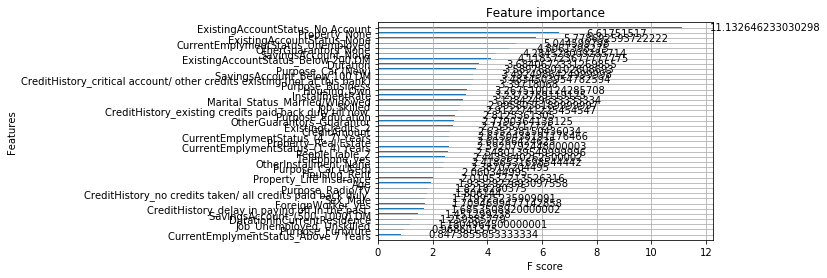

In [219]:
xgboost.plot_importance(xgfit, importance_type='gain')


In [0]:
xg_1 = xgboost.XGBClassifier()
xg_1.fit(X_train1, y_train)
y_pred = xg_1.predict(X_test1)


In [0]:
importance = pd.DataFrame(xg_1.feature_importances_, index=X_train.columns, 
                          columns=["Importance"])
importance = importance.sort_values(by=['Importance'], ascending=False)[0:15]

In [222]:
importance

,Importance
ExistingAccountStatus_No Account,0.089783
Property_None,0.053369
ExistingAccountStatus_None,0.046604
CurrentEmplymentStatus_Unemployed,0.040684
OtherGuarantors_None,0.038761
SavingsAccount_None,0.034554
ExistingAccountStatus_Below 200 DM,0.033216
Duration,0.029712
Purpose_Car (New),0.028951
SavingsAccount_Below 100 DM,0.028167


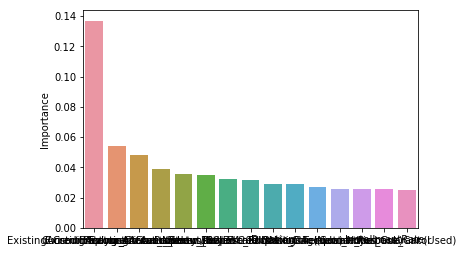

In [177]:
sns.barplot(importance.index, importance['Importance'], orient='v' )


In [0]:
import numpy as np

from treeinterpreter import treeinterpreter as ti

In [0]:
y = np.array([0 if i == 1 else 1 for i in y])


In [0]:
X_train, X_test, y_train, y_test = reset_data()

In [224]:
metrics.precision_recall_fscore_support(y_pred, y_test)

(array([0.87619048, 0.51111111]),
 array([0.80701754, 0.63888889]),
 array([0.84018265, 0.56790123]),
 array([228,  72]))